In [6]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np

dataDir = '../dataset/images' # Change this, according to your images' directory path

In [7]:
img = cv2.imread(os.path.join(dataDir, 'road57.png')) # Change this, according to your image's path

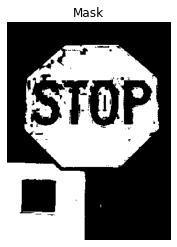

In [10]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#obtain the grayscale image of the original image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#set the bounds for the red hue
lower_red = np.array([0,100,100])
upper_red = np.array([20,255,255])

#create a mask using the bounds set
mask = cv2.inRange(hsv, lower_red, upper_red)
#create an inverse of the mask
mask_inv = cv2.bitwise_not(mask)
#Filter only the red colour from the original image using the mask(foreground)
res = cv2.bitwise_and(img, img, mask=mask)
#Filter the regions containing colours other than red from the grayscale image(background)
background = cv2.bitwise_and(gray, gray, mask = mask_inv)
#convert the one channelled grayscale background to a three channelled image
background = np.stack((background,)*3, axis=-1)
#add the foreground and the background
added_img = cv2.add(res, background)

mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
mask_inv = cv2.cvtColor(mask_inv, cv2.COLOR_BGR2RGB) # convert from BGR to RGB because we are using matplotlib to display the image
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
added_img = cv2.cvtColor(added_img, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(hsv, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(gray, cv2.COLOR_BGR2RGB)

plt.imshow(mask)
plt.title('Mask')
plt.axis('off')
plt.show()

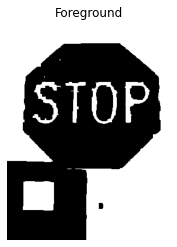

In [11]:
imgGray = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
ret, thresh = cv2.threshold(imgGray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Removing Noise
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

# Getting the background area
bg = cv2.dilate(opening,kernel,iterations=3)
bg = cv2.erode(opening,kernel,iterations=3)

plt.imshow(bg, cmap='gray')
plt.title('Foreground')
plt.axis('off')
plt.show()

In [26]:
# bgCopy = cv2.cvtColor(bg,cv2.COLOR_GRAY2RGB)

# Apply the Hough circle transform
detectionMethod = cv2.HOUGH_GRADIENT # corresponds to the canny filter
resolutionFlag = 1 # same resolution as the original image
minDistance = 20 # between the centers of the detected circles

# param1 and param2 are the thresholds passed to the detection method 
circles = cv2.HoughCircles(bg, detectionMethod, resolutionFlag, minDistance, param1=200, param2=100, minRadius=0, maxRadius=0)
circles = np.uint16(np.around(circles))

# Drawing the resulting circles
for i in circles[0,:]: 
    cv2.circle(bgCopy,(i[0],i[1]),i[2],(0,255,0),2)

plt.imshow(bgCopy)
plt.title('Hough Circle Transform Result')
plt.axis('off')
plt.show()